In [13]:
"""
General imports and loading of the audio file for development and explorative research.
The audio signal is normalized in the time domain to its highest value.
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os
%run transient_shaper_lib.ipynb

SAMPLE_LENGTH = 10

def read_audio_files(directory):
  """
  Reads all audio files from a directory and returns their data with file name labels.

  Args:
      directory: The directory path (string).

  Returns:
      A list of tuples, where each tuple contains:
          - The audio data as a NumPy array.
          - The filename (without extension).
  """

  audio_data_list = []
  for filename in os.listdir(directory):
    if filename.endswith(".wav"):  # Check for .wav files
        filepath = os.path.join(directory, filename)
        sample_rate, audio_data = sp.io.wavfile.read(filepath)
        try:
          audio_data = audio_data[:, 0]
        except:
          pass
        n_bits = 32  # Assuming 32-bit audio
        audio_data = audio_data / (2**(n_bits - 1))  # Adjust range to -1 to 1 
        audio_data /= np.abs(np.max(audio_data))  # Safer normalization
        audio_data = audio_data[: sample_rate * SAMPLE_LENGTH]
        label = os.path.splitext(filename)[0]  # Extract filename without extension
        audio_data_list.append((audio_data, label, sample_rate))

  return audio_data_list

audio_data_with_labels = read_audio_files(os.getcwd())

print("Audio data and labels:")
for audio_data, label, sample_rate in audio_data_with_labels:
  print(f"- Label: {label}, Audio data shape: {audio_data.shape}, Sample rate: {sample_rate}")

FRAME_LEN = 1   # in s


Audio data and labels:
- Label: 26 - Jorja Smith - Teenage Fantasy, Audio data shape: (491054,), Sample rate: 96000
- Label: 31 - 20230420_fern von mir, Audio data shape: (800250,), Sample rate: 96000


In [14]:
sampleRate = 96000
BEAT_DETECTION_BUFFER_SIZE = 64
AUDIO_BUFFER_SIZE_S = 8
AUDIO_BUFFER_SIZE = sampleRate * AUDIO_BUFFER_SIZE_S
MAX_ONSETS = 4 * AUDIO_BUFFER_SIZE_S # 4 BPS IS 240 BPM


from ctypes import *
from typing import Literal
lib = CDLL("../src/af/AFInC.dll")  # Adjust path accordingly

lib.resetBuffer.argtypes = []
lib.resetBuffer.restype = None

lib.initAf.argtypes = []
lib.initAf.restype = None

lib.AFInCAppend.argtypes = [c_double]
lib.AFInCAppend.restype = None

lib.AFInCProcess.argtypes = []
lib.AFInCProcess.restype = None

lib.afGetT1A.argtypes = []
lib.afGetT1A.restype = c_double

lib.afGetT2A.argtypes = []
lib.afGetT2A.restype = c_double

lib.afGetTempo.argtypes = []
lib.afGetTempo.restype = c_double

lib.afGetSpectralCentroid.argtypes = []
lib.afGetSpectralCentroid.restype = c_double

lib.afGetSpectralFlatness.argtypes = []
lib.afGetSpectralFlatness.restype = c_double

# ----------------------------------------
# debug helpers
# ----------------------------------------
lib.__getAudioBuffer.argtypes = []
lib.__getAudioBuffer.restype = c_double

lib.__getEnvBuffer.argtypes = []
lib.__getEnvBuffer.restype = c_double

lib.__getOnsetBuffer.argtypes = []
lib.__getOnsetBuffer.restype = c_double

lib.__getTA1Buffer.argtypes = []
lib.__getTA1Buffer.restype = c_double

lib.__getTA2Buffer.argtypes = []
lib.__getTA2Buffer.restype = c_double

lib.__getBeatMagnitude.argtypes = [c_int]
lib.__getBeatMagnitude.restype = c_double

lib.__resetIndexDebug.argtypes = []
lib.__resetIndexDebug.restype = None






26 - Jorja Smith - Teenage Fantasy
--- AF in C features ---
Tempo:  175.78125
TA1:  0.029604166666666668
TA2:  0.15771875
Mean spectral centroid: 6178 Hz
Mean spectral flatness: 0.41342662764126253
-------
TA1 python percentile:  0.029604166666666668
TA2 python percentile::  0.15771875
32
(32, 512)


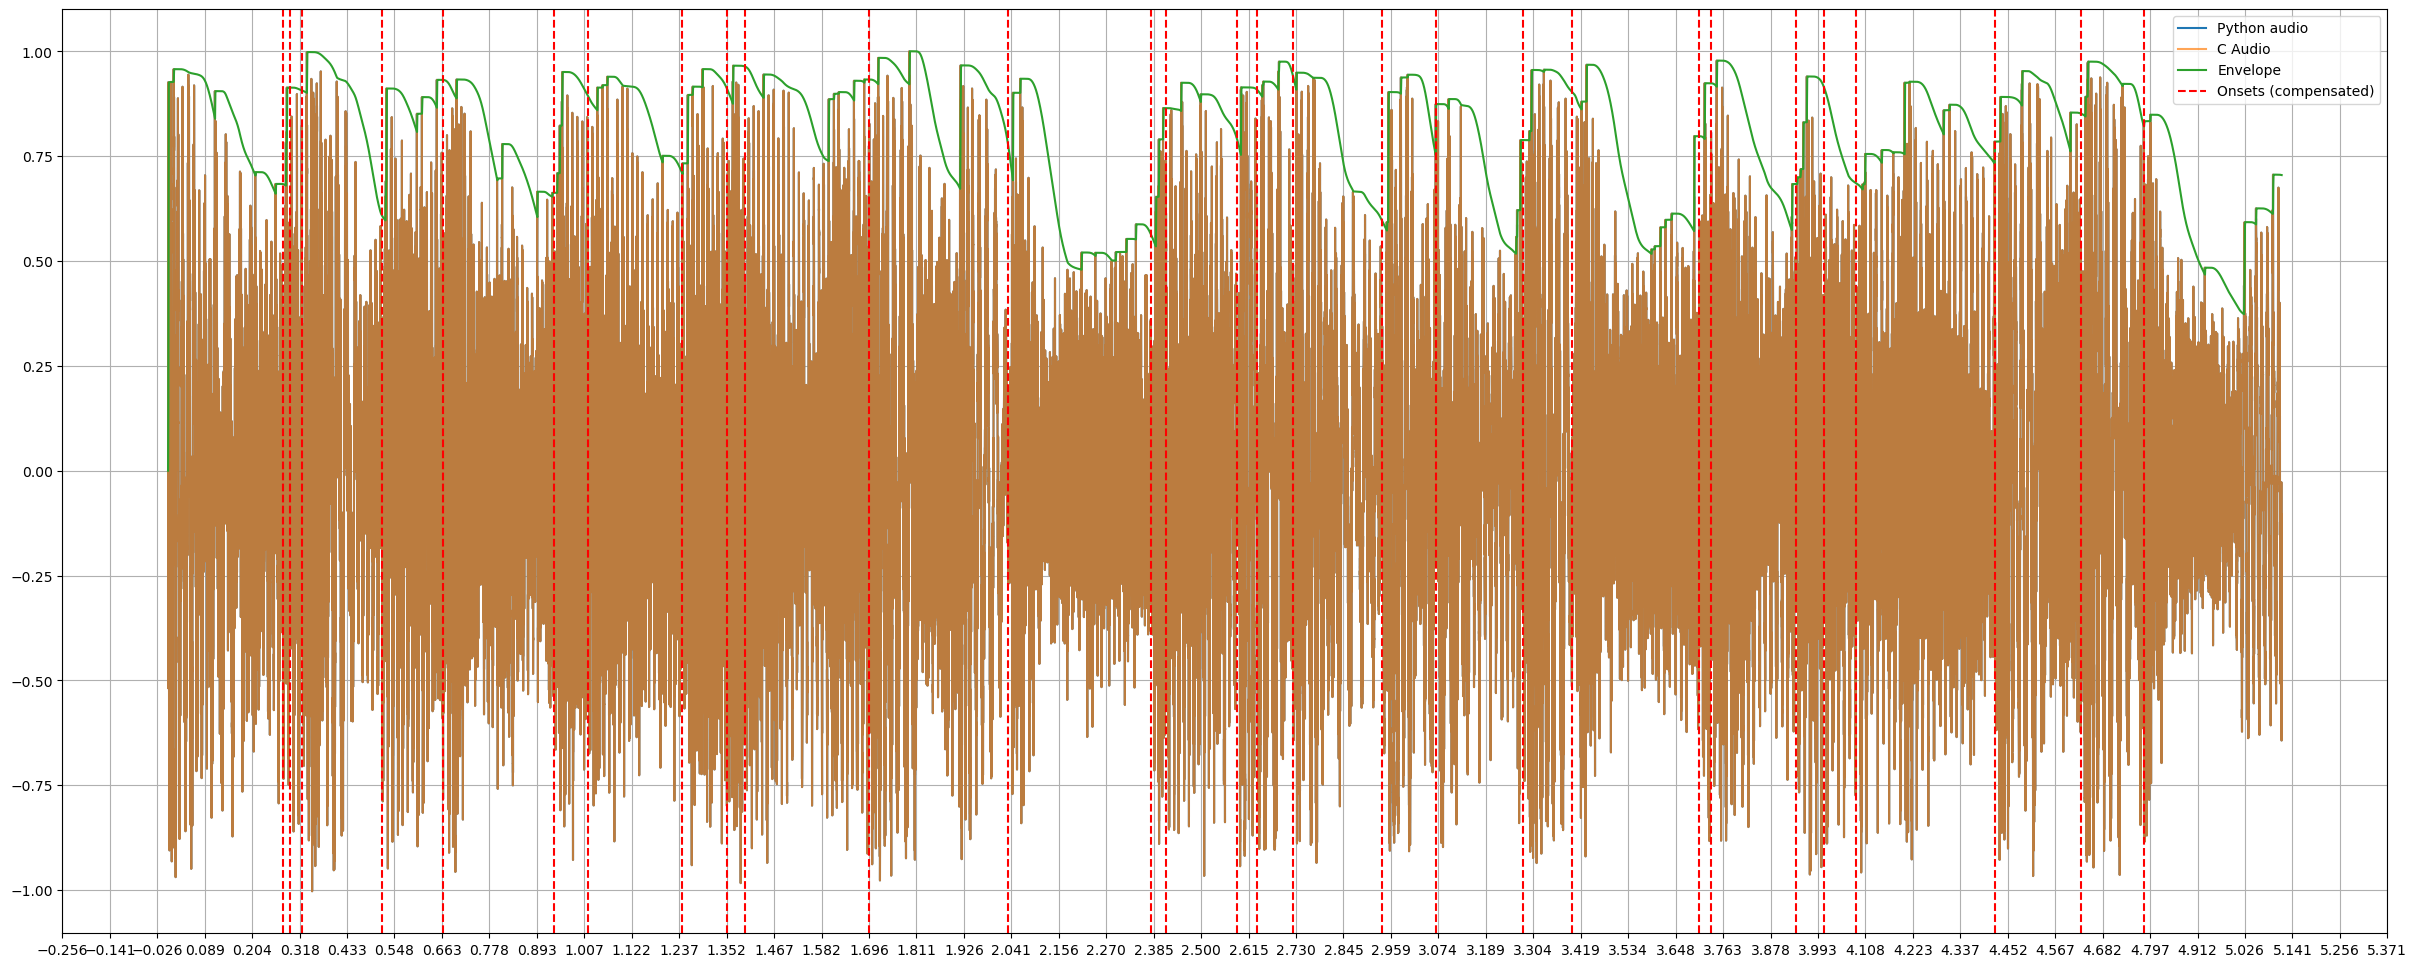

C:\Users\kriso\AppData\Local\Temp\ipykernel_15060\1785701284.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


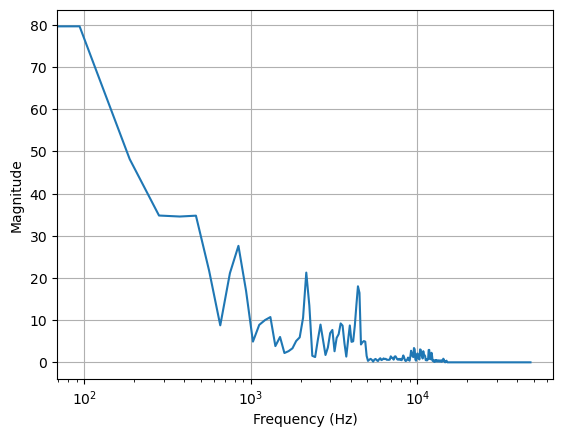

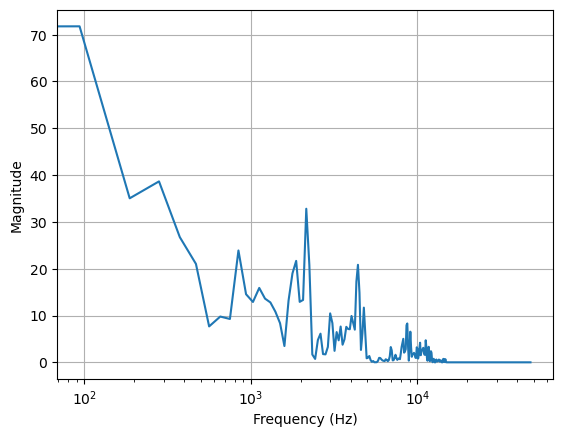

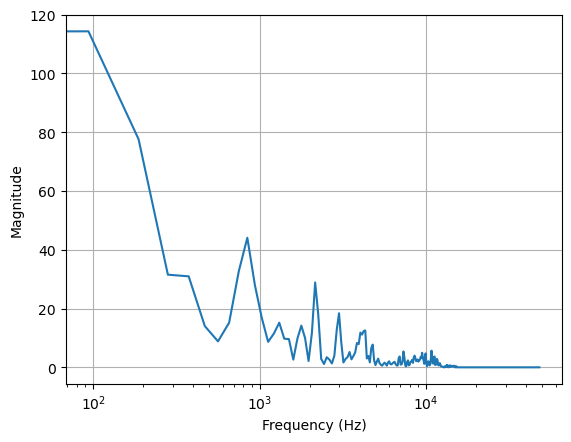

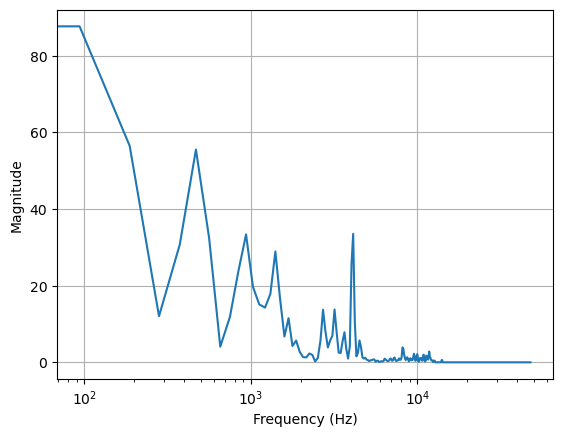

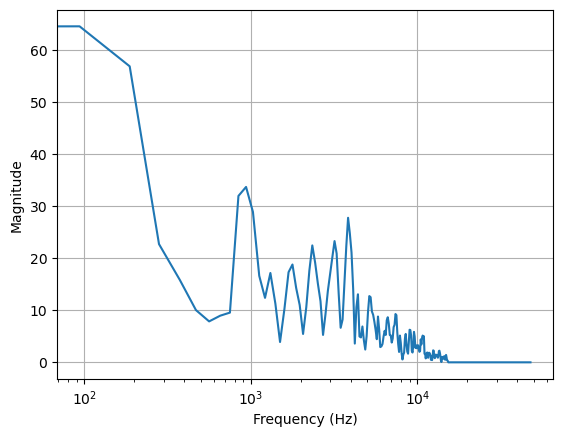

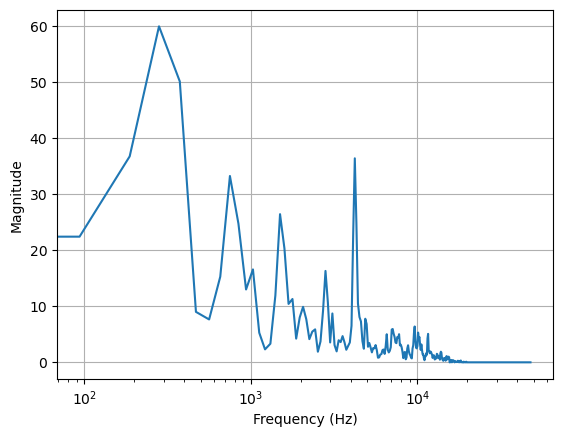

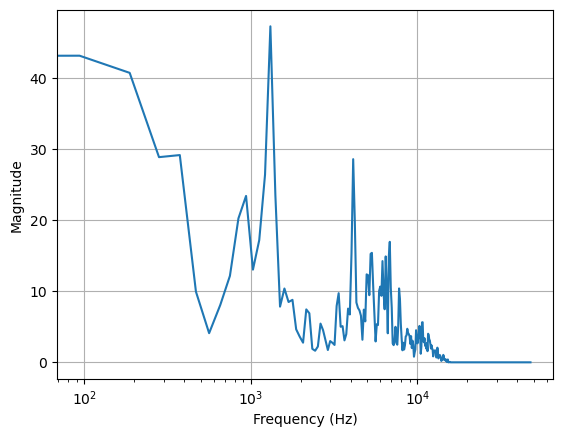

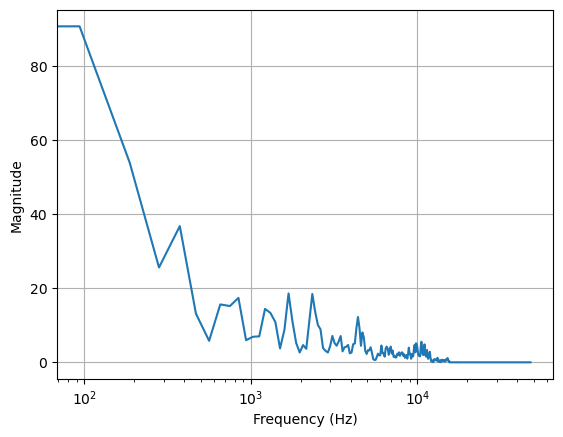

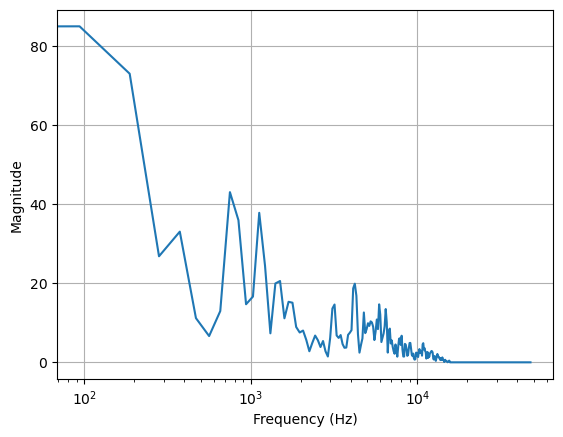

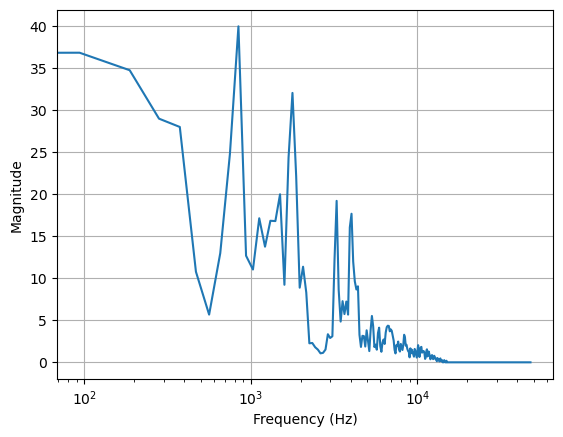

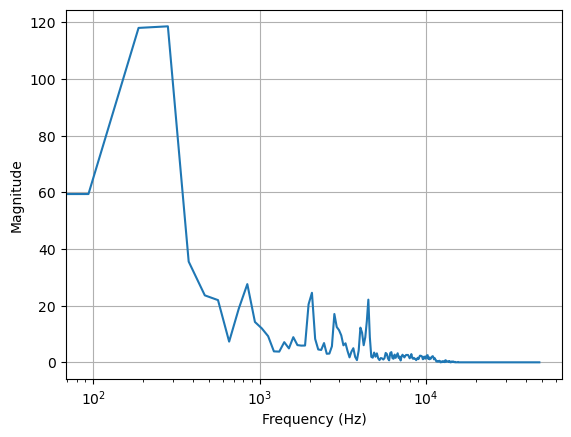

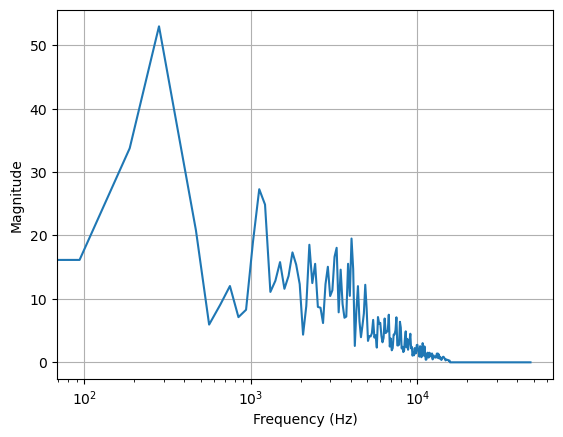

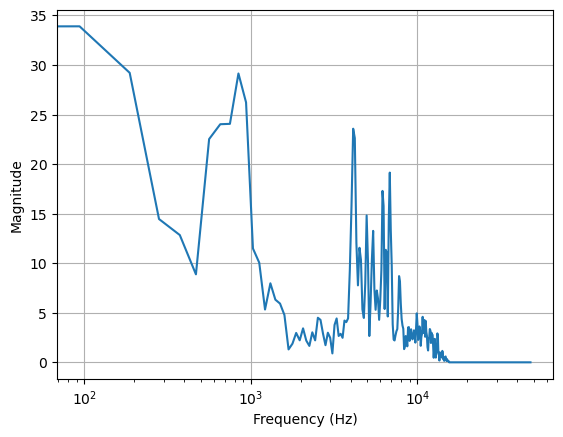

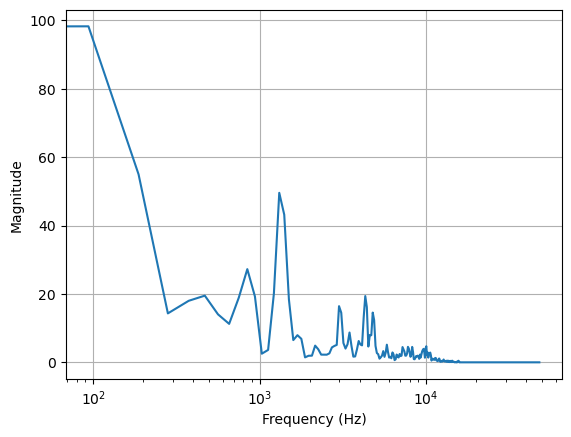

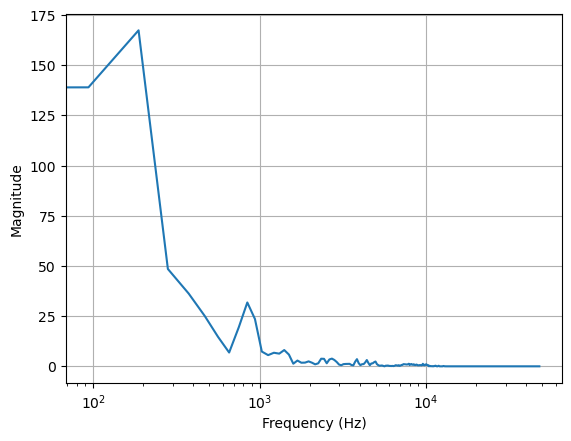

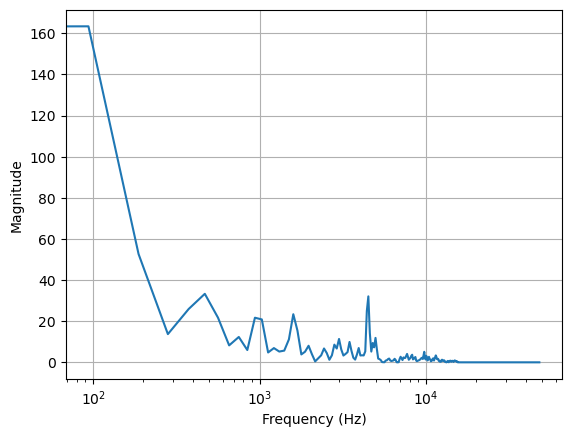

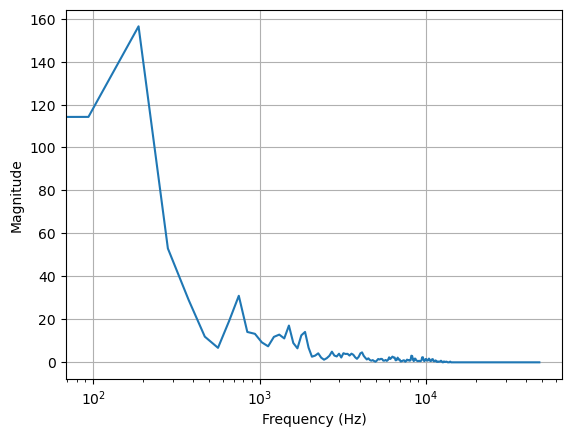

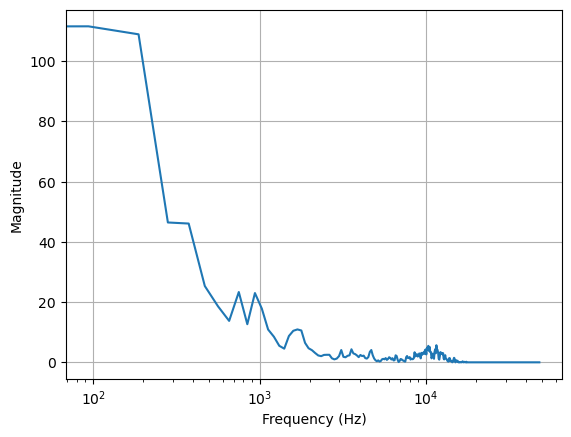

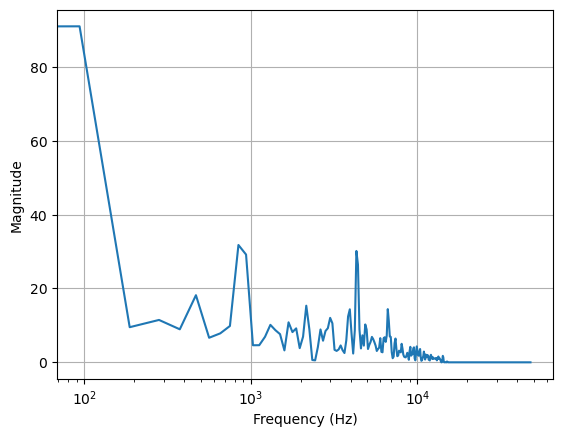

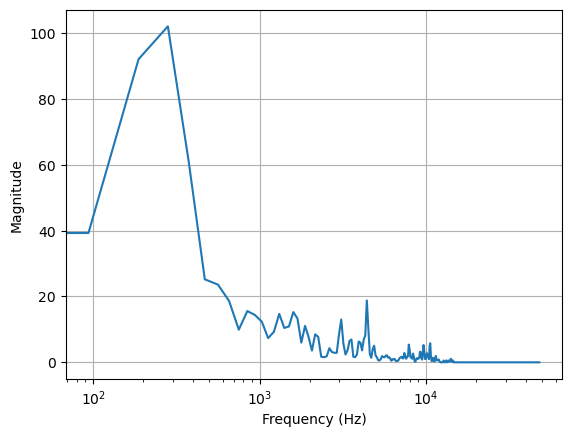

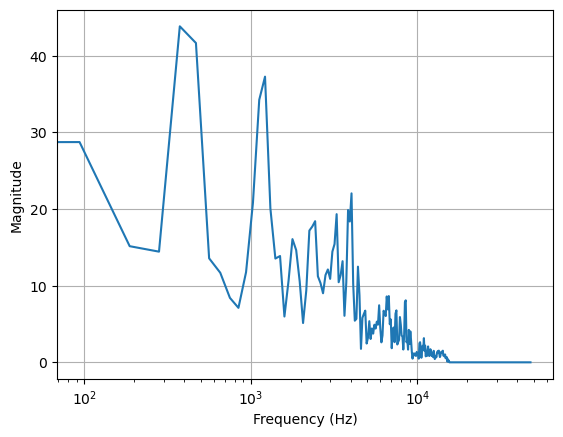

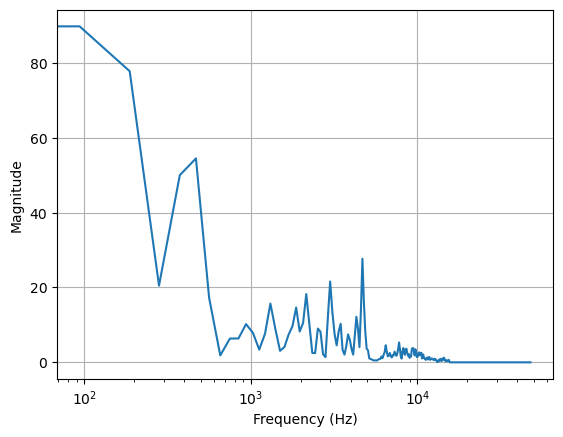

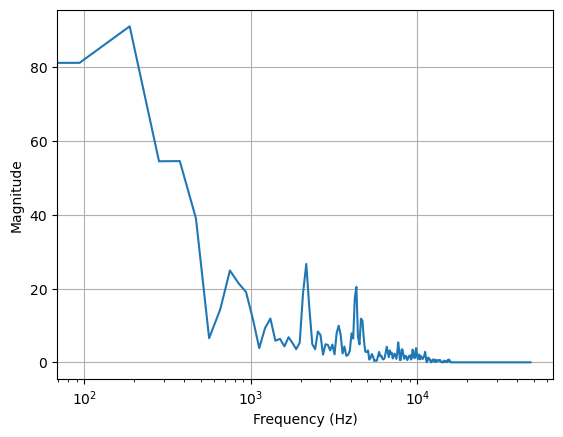

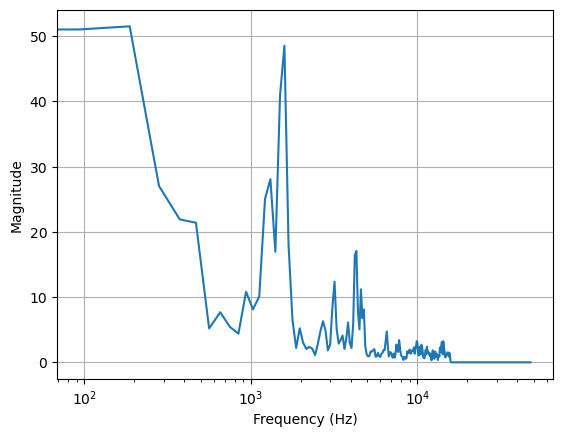

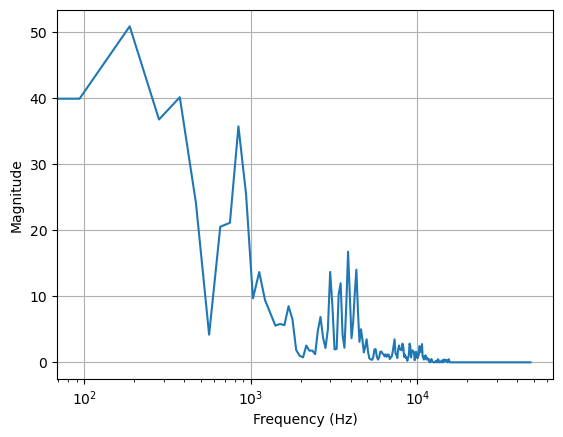

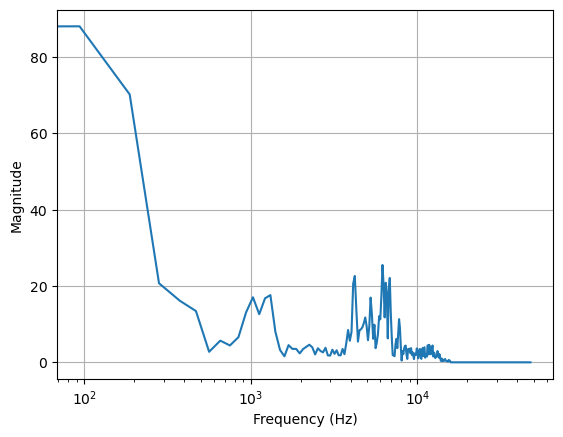

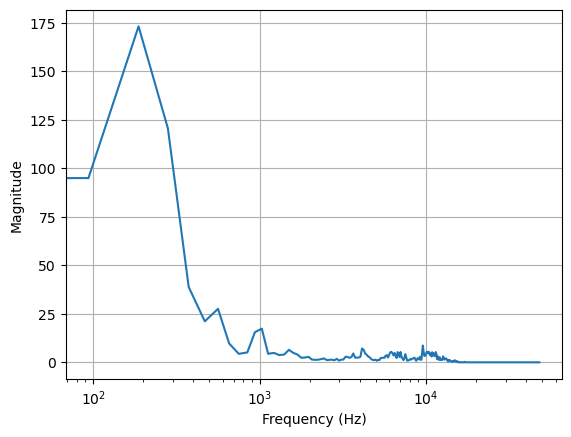

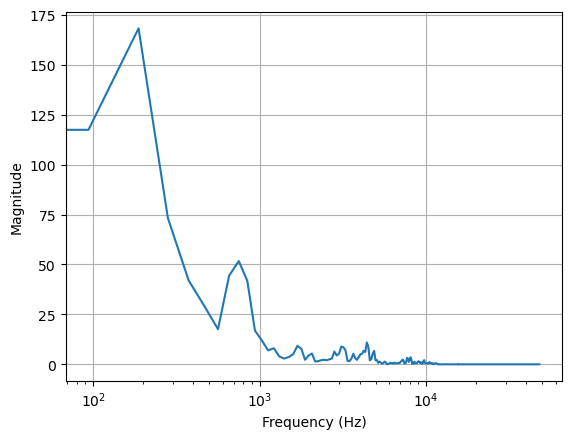

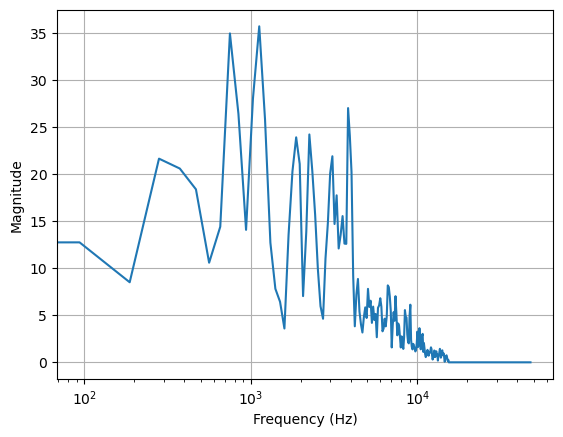

31 - 20230420_fern von mir
--- AF in C features ---
Tempo:  166.66666666666666
TA1:  0.022458333333333334
TA2:  0.15909375
Mean spectral centroid: 5003 Hz
Mean spectral flatness: 0.28478771639617656
-------
TA1 python percentile:  0.022513020833333335
TA2 python percentile::  0.15996875
32
(32, 512)


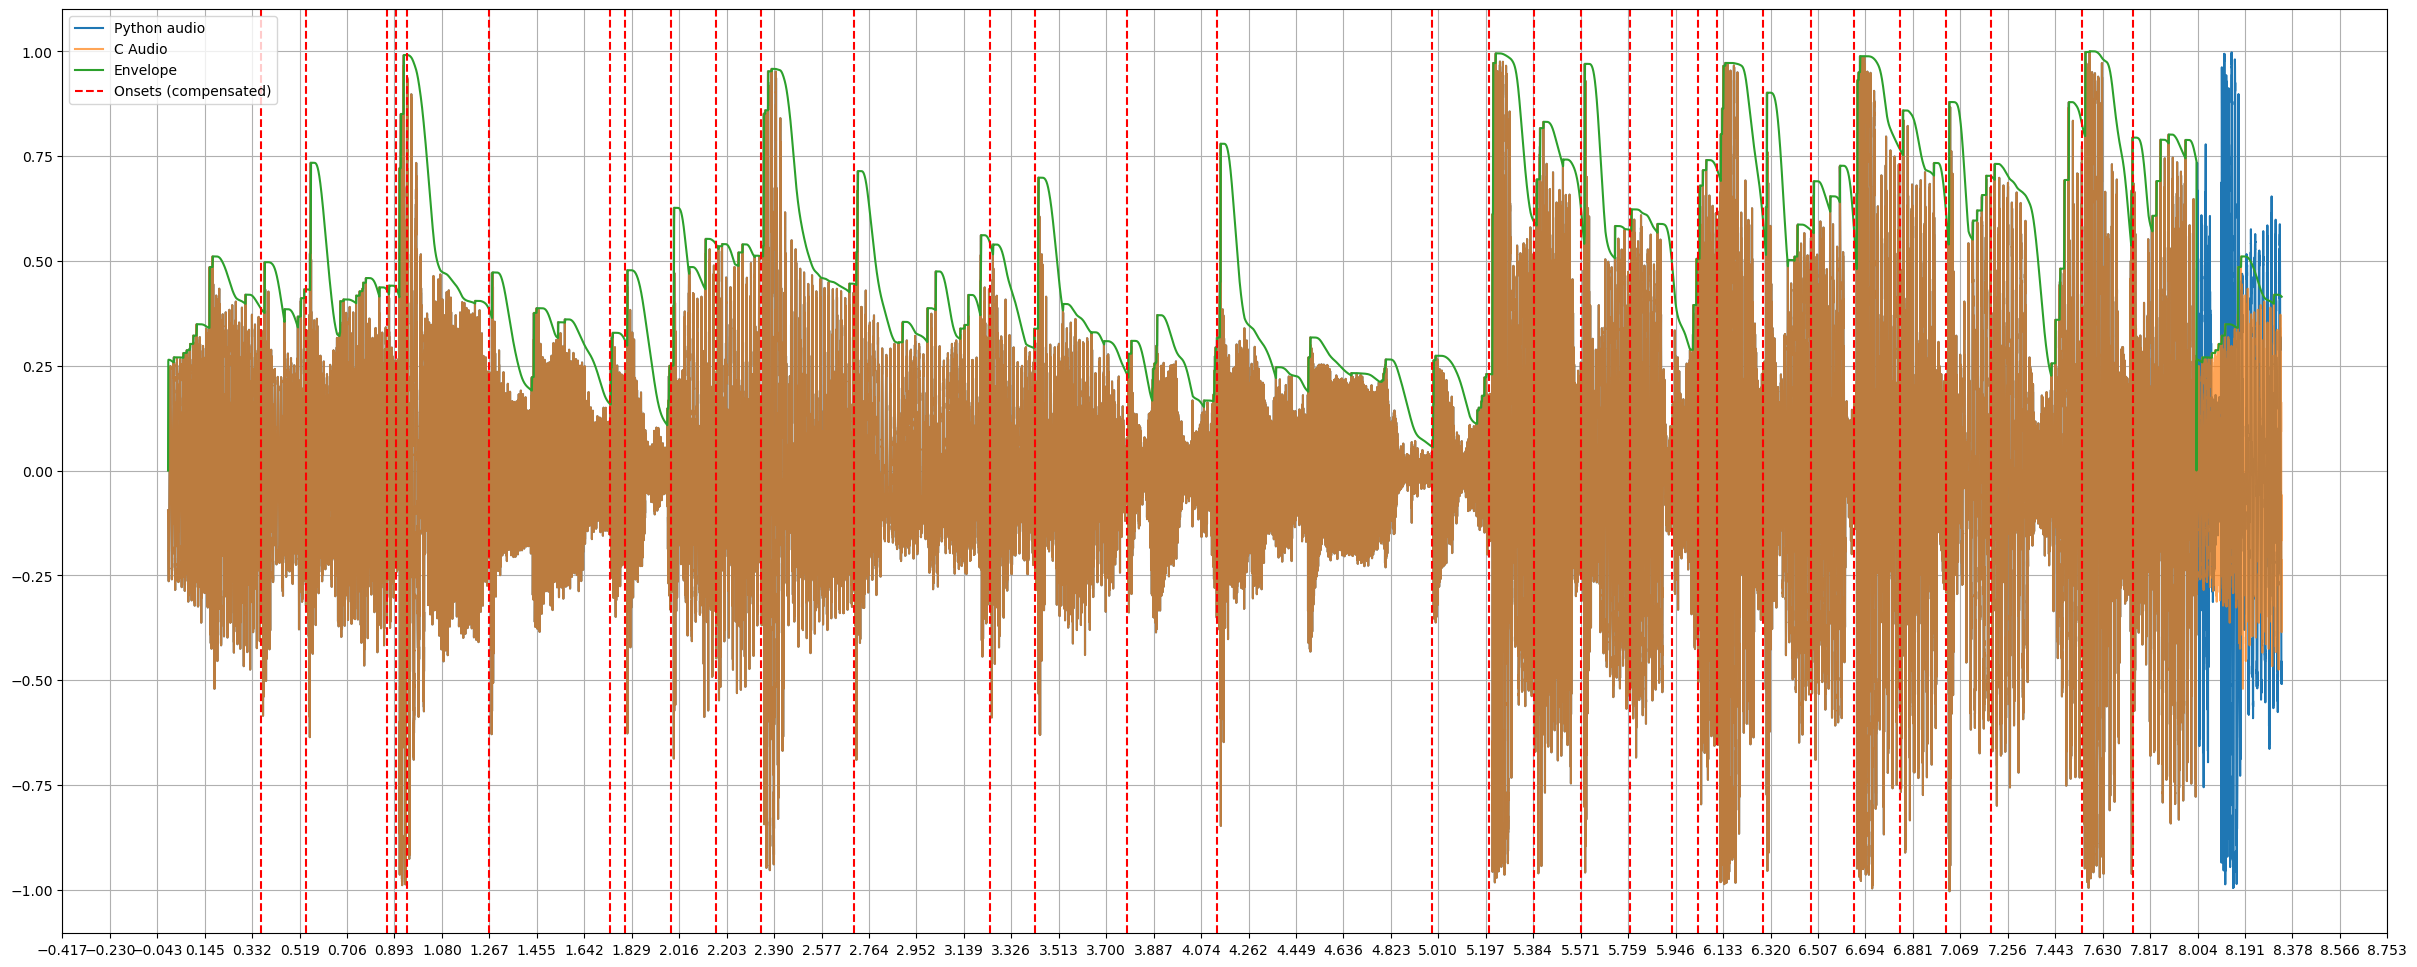

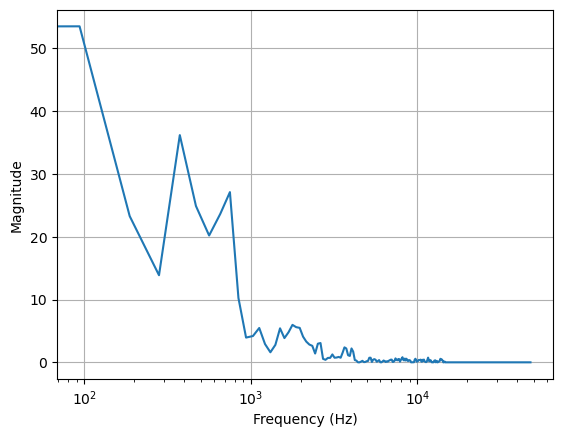

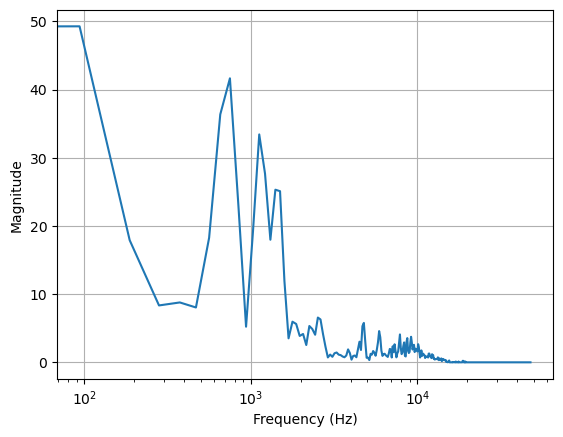

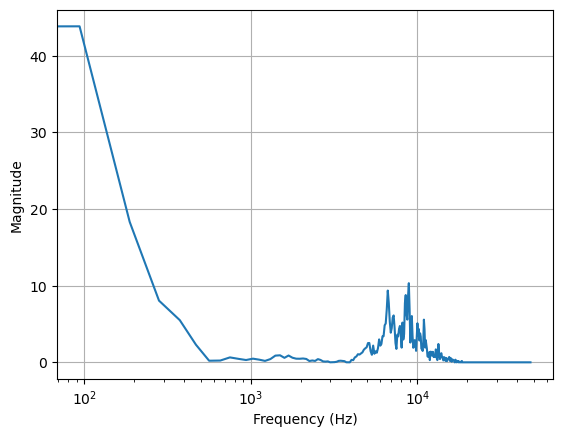

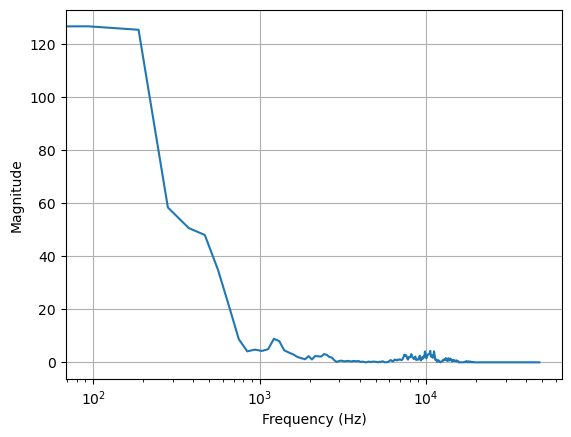

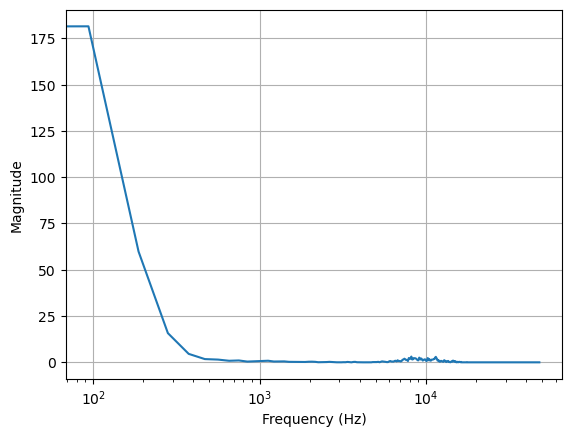

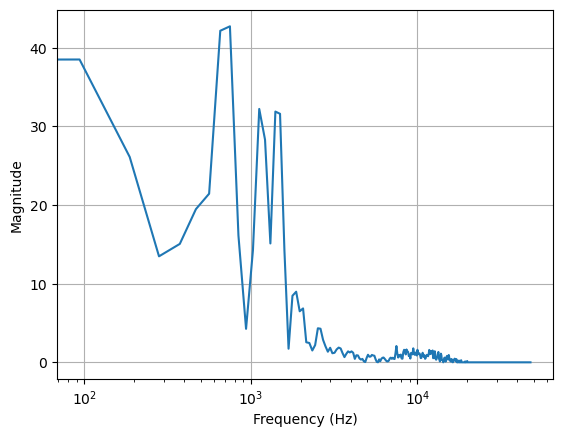

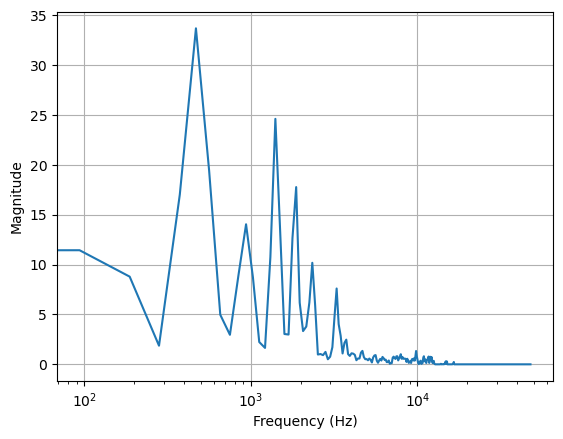

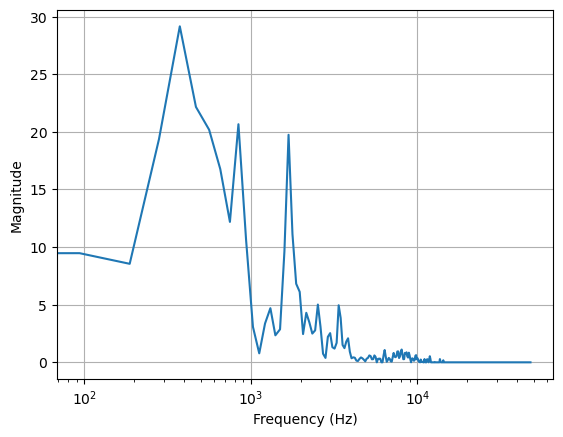

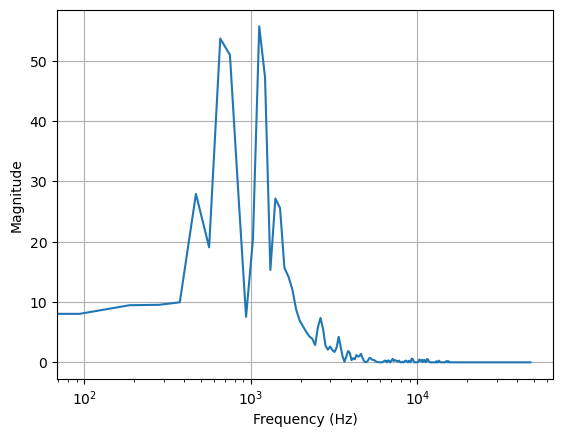

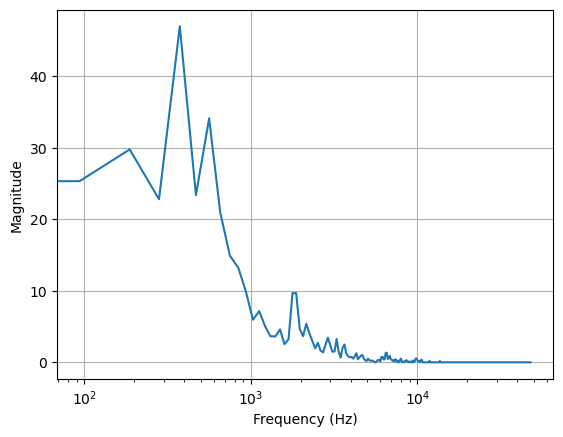

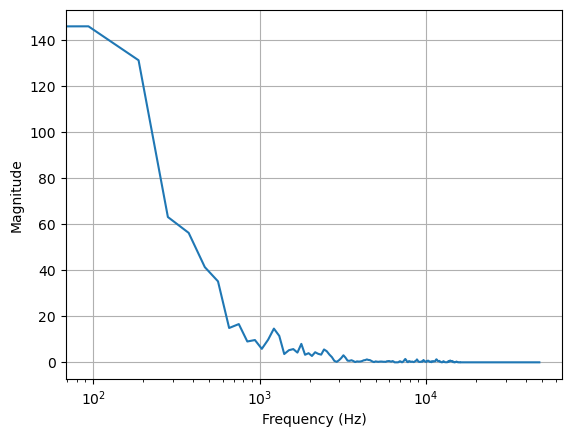

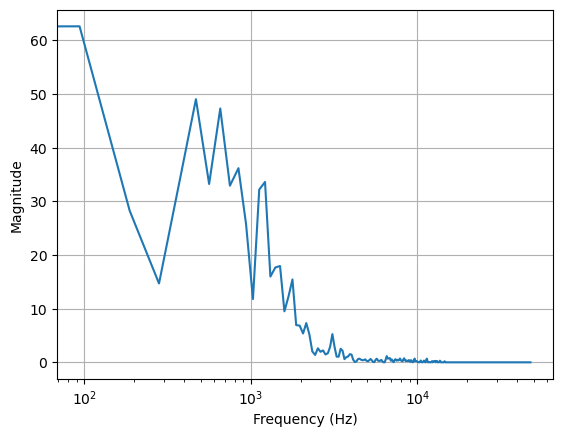

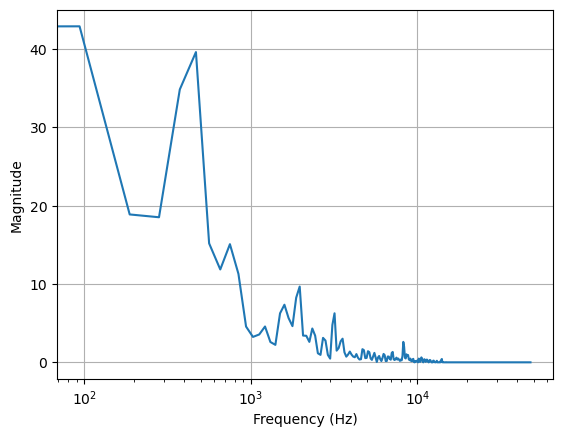

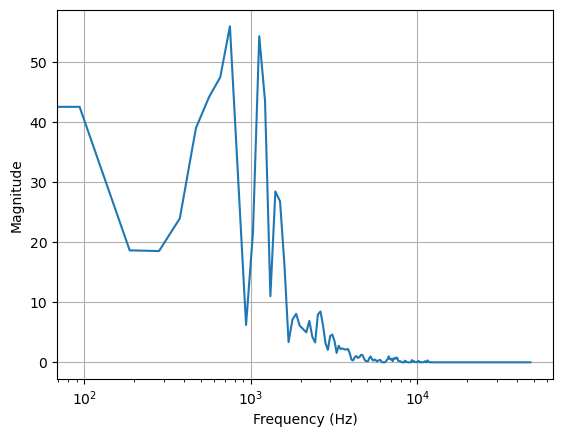

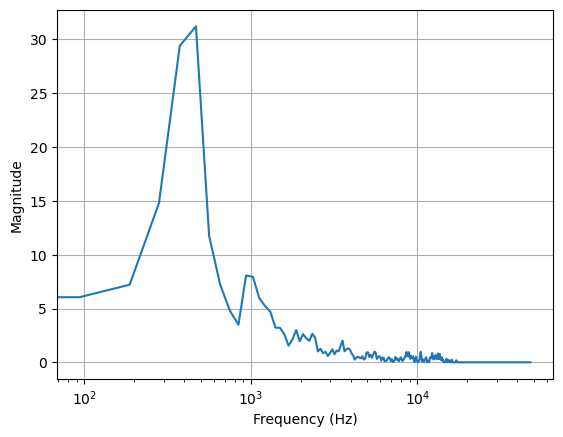

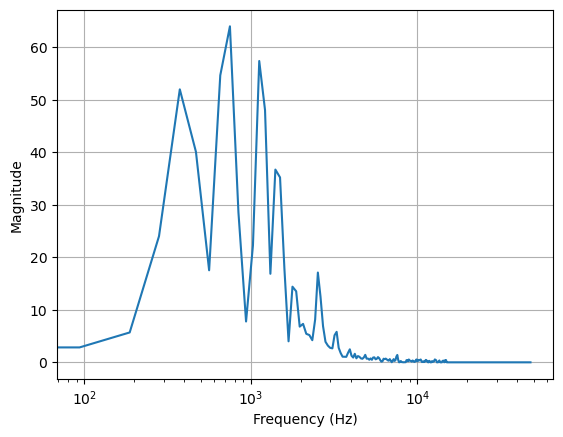

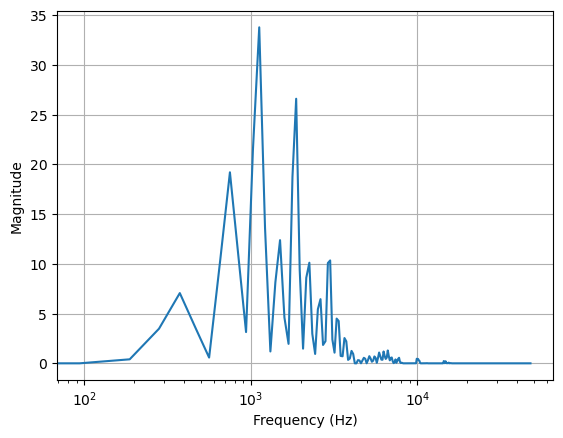

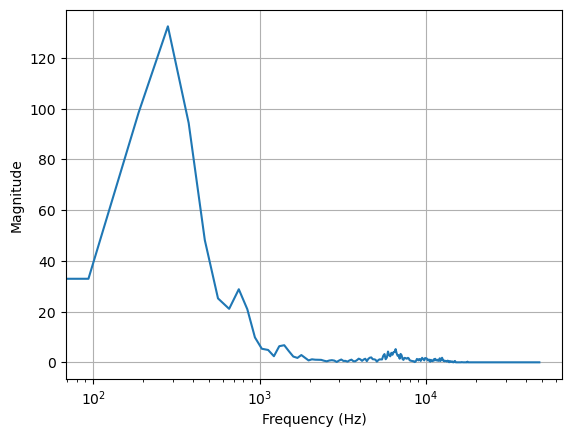

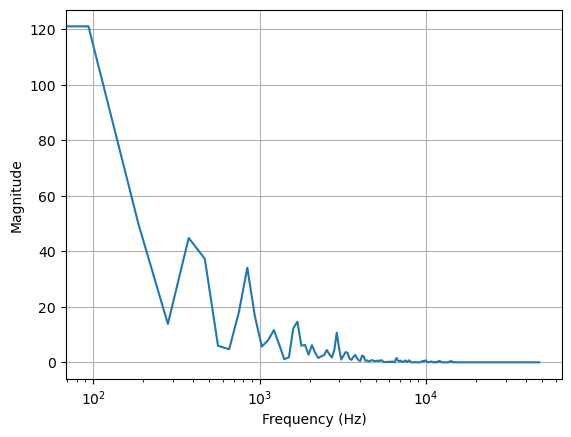

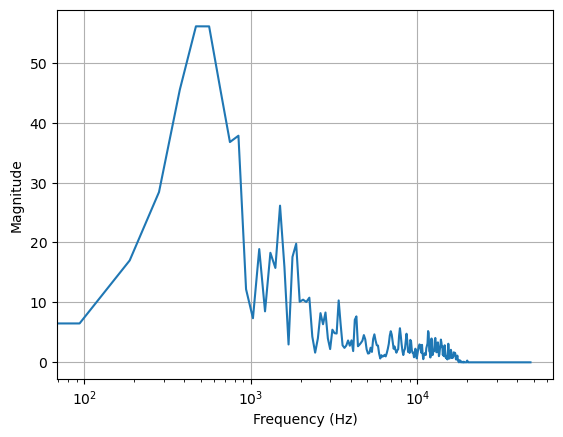

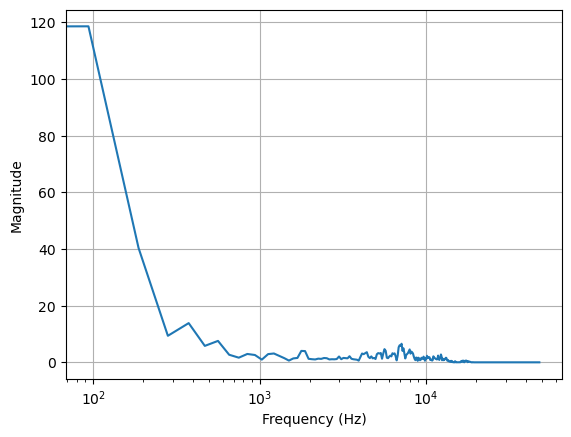

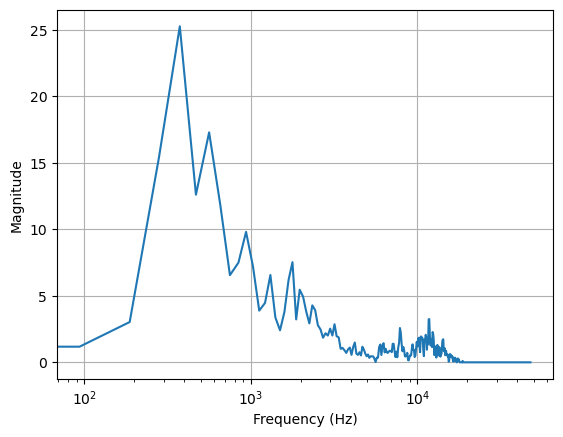

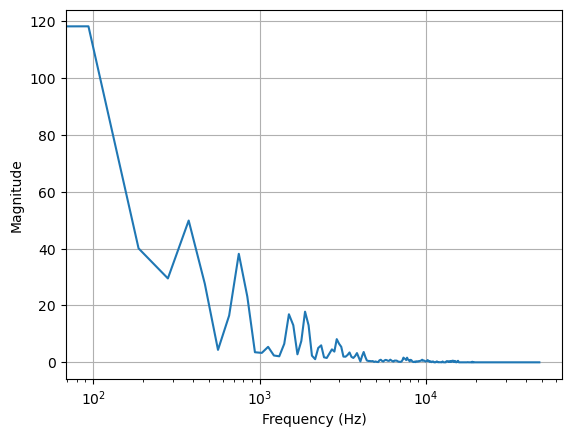

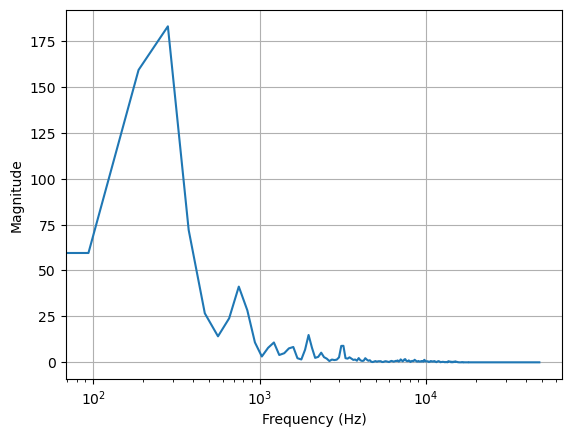

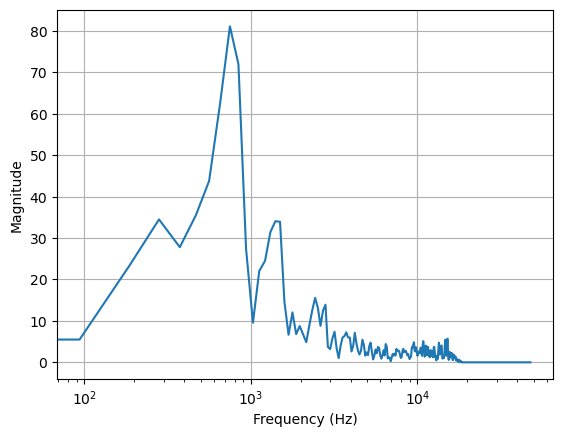

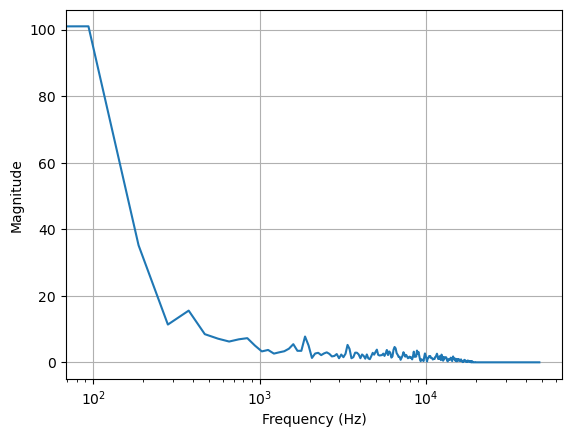

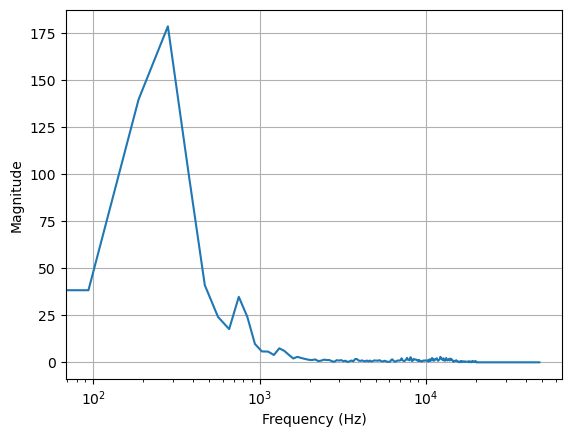

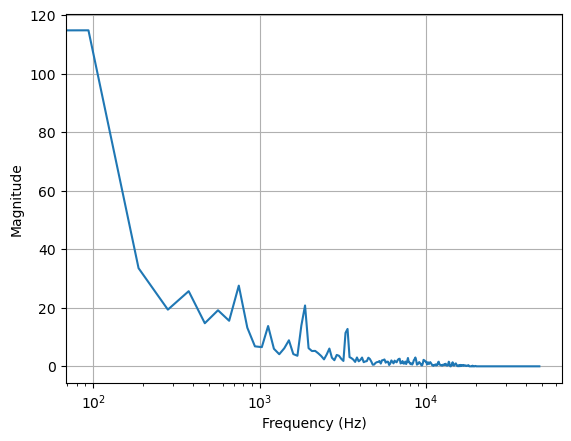

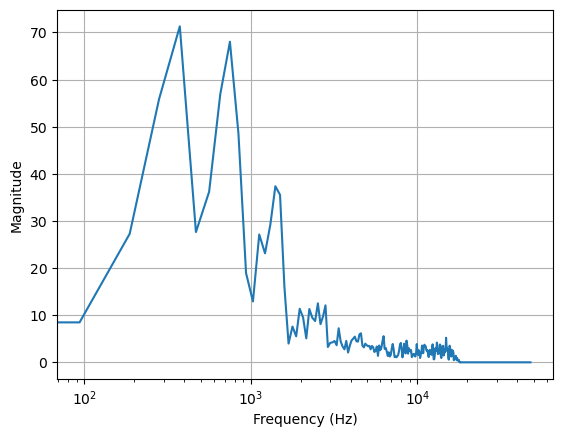

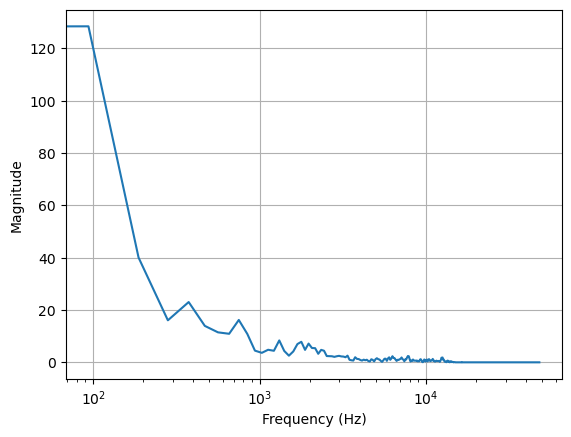

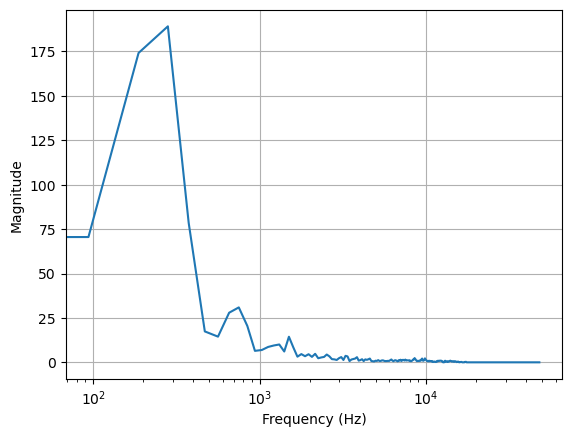

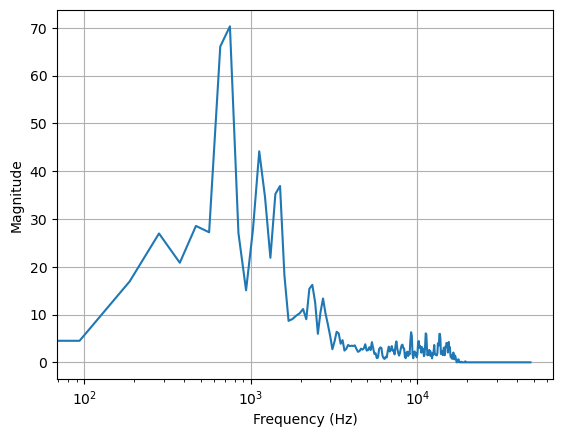

In [15]:
for song in audio_data_with_labels:
    lib.__resetIndexDebug()

    target_device_audio_buffer = []
    envelope = []
    onsets = []
    TA1Buffer = []
    TA2Buffer = []
    magnitudePerBeat = np.zeros((512 * MAX_ONSETS // 512, 512))
    lib.initAf()
    lib.resetBuffer()

    print(song[1])
    for sample in song[0]:
        lib.AFInCAppend(sample)

    lib.AFInCProcess()
    
    print("--- AF in C features ---")
    print("Tempo: ", lib.afGetTempo())
    print("TA1: ", lib.afGetT1A() / sample_rate)
    print("TA2: ", lib.afGetT2A() / sample_rate)
    print("Mean spectral centroid:", int(lib.afGetSpectralCentroid()), "Hz")
    print("Mean spectral flatness:", lib.afGetSpectralFlatness())
    print("-------")
    
    for sample in song[0]:
        target_device_audio_buffer.append(lib.__getAudioBuffer())
        envelope.append(lib.__getEnvBuffer())
    
    for onset in range(MAX_ONSETS):
        currentOnset = lib.__getOnsetBuffer()
        if(currentOnset == 0):
            break
        currentTA1 = lib.__getTA1Buffer() / sample_rate
        curretnTA2 = lib.__getTA2Buffer() / sample_rate
        onsets.append(currentOnset)
        TA1Buffer.append(currentTA1)
        TA2Buffer.append(curretnTA2)

    print("TA1 python percentile: ", np.percentile(TA1Buffer, 75))
    print("TA2 python percentile:: ", np.percentile(TA2Buffer, 75))
    print(len(magnitudePerBeat))
    for perBeat, value in enumerate(onsets):
        for bin in range(0,512):
            magnitudePerBeat[perBeat,bin] = lib.__getBeatMagnitude(perBeat)

    print(np.shape(magnitudePerBeat))
    plt.figure(figsize=(30, 12))
    ax = plt.gca()  # Get the current axes for customization
    ax.xaxis.set_major_locator(ticker.LinearLocator(numticks=50))

    plt.plot([i/sampleRate for i in range(len(song[0]))], song[0], label="Python audio")
    plt.plot([i/sampleRate for i in range(len(target_device_audio_buffer))], target_device_audio_buffer, alpha=0.7, label="C Audio")
    plt.plot([i/sampleRate for i in range(len(envelope))], envelope, label="Envelope")
    for i, onset in enumerate(onsets):
        if int(onset) != 0:
            if i == 0:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--', label="Onsets (compensated)")
            else:
                plt.axvline(x=int(onset)/sampleRate, color='r', linestyle='--')
        
    plt.legend()
    plt.grid()
    plt.show()

    for spec in magnitudePerBeat:
        if np.mean(spec) != 0:
            n = len(spec)
            freq = np.arange(0, sample_rate / 2, sample_rate / n / 2)
            plt.figure()
            plt.grid()
            plt.semilogx(freq, spec)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
    plt.show()
